/Users/koulikkhamaru/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


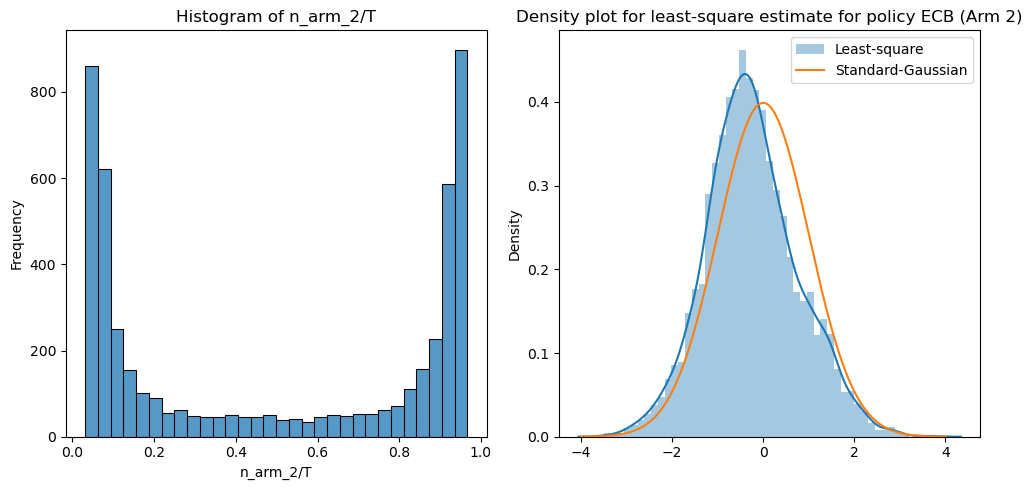

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(1234)

# Trial repetitions and trial size
R = 5000 # Number of repeat
T = 1000 # Total number of arm-pulls
K = 2
ECB_epsilon = 0.1

# Reward and noise parameters
noise_param = 1.0
reward_means = np.array([0.3, 0.3])
reward_vars = np.array([1/(2*noise_param + 1.0)] * K)

# Prior parameters
mu0 = 0.4
var0 = 1/(2*noise_param + 1.0)

# Epsilon-greedy policy
def ECB(mu_post, var_post, epsilon=ECB_epsilon):
    use_cb = np.random.binomial(1, 1.0-epsilon)
    if use_cb:
        arm = np.argmax(mu_post)
    else:
        arm = np.random.choice(range(K))
    return arm

# Gather data
least_squares_errors = []
arm2_ratios = []

for r in range(R):
    mu_post = np.repeat(mu0, K)
    var_post = np.repeat(var0, K)
    
    rewards = []
    arms_selected = []
    
    for t in range(T):
        if t < K:
            arm = t
        else:
            arm = ECB(mu_post, var_post, epsilon=ECB_epsilon)
        
        reward = 2*np.random.beta(noise_param, noise_param) - 1.0 + reward_means[arm]
        
        new_var = 1.0 / (1.0 / var_post[arm] + 1.0 / reward_vars[arm])
        mu_post[arm] = (mu_post[arm] / var_post[arm] + reward / reward_vars[arm]) * new_var
        var_post[arm] = new_var
        
        rewards.append(reward)
        arms_selected.append(arm)
    
    # Compute least squares estimator for arm 2 (index 1)
    rewards_arm_2 = np.array([rewards[i] for i in range(T) if arms_selected[i] == 1])
    n_arm_2 = len(rewards_arm_2)
    arm2_ratios.append(n_arm_2 / T)
    if n_arm_2 > 0:
        least_squares_estimate = np.mean(rewards_arm_2)
        true_mean = reward_means[1]
        std_error = np.std(rewards_arm_2) / np.sqrt(n_arm_2)
        standardized_error = (least_squares_estimate - true_mean) / std_error
        least_squares_errors.append(standardized_error)

        
colors = {}
colors['OLS_gsn'] = sns.color_palette()[0]
colors['Normal'] = sns.color_palette()[1]

        
# Plot histogram of n_arm_2/T
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(arm2_ratios, bins=30, kde=False, color=colors['OLS_gsn'])
plt.title('Histogram of n_arm_2/T')
plt.xlabel('n_arm_2/T')
plt.ylabel('Frequency')

# Plot the density of the standardized errors
plt.subplot(1, 2, 2)
rvs_LS = least_squares_errors


# Plot histogram and density of rvs_LS
sns.distplot(rvs_LS, hist=True, kde=True, label="Least-square", color = colors['OLS_gsn'])

# Plot standard normal density
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)
plt.plot(x, y, label="Standard-Gaussian", color=colors['Normal'])


plt.legend()
plt.title('Density plot for least-square estimate for policy ECB (Arm 2)')
plt.tight_layout()
plt.show()

